## Read me

This project uses PRAW (Python Reddit API Wrapper), which requires Reddit OAuth2 credentials to function properly.
To get started, please refer to Reddit’s OAuth2 Quick Start Guide (https://github.com/reddit-archive/reddit/wiki/OAuth2) for setup instructions.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import praw
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import requests
import torch
from wordcloud import WordCloud
from datetime import datetime, UTC

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

c:\Jupyter Notebooks\EA Sentiment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 - Reddit Scraping

### 1.1 Scraping Reddit Posts with Praw

In [ ]:
# Initiating praw
reddit = praw.Reddit(user_agent_= True,
                    client_id = 'IOp3ITKzTC--OYAJ4NKTEQ',   # Fill in Reddit API keys for scraping
                    client_secret = "rya-f8rTVg1ShDMA3ePeU6WGnEsa5w",
                    user_agent = "SentimentAnalysis:v1.0 (by /u/obsc0wing)",  
)


# Selecting Subreddit
subreddit = reddit.subreddit("leagueoflegends")
query = "mastercard"

In [4]:
# Creating the list for the post df
postID = []
author = []
title = []
timestamp = []
score = []
body = []
commentIDs = []

# Appending the array
for post in subreddit.search(query, sort = "relevant", limit = 25):
    postID.append(post.id),
    author.append(post.author),
    title.append(post.title),
    timestamp.append(post.created_utc)
    score.append(post.score),
    body.append(post.selftext),
    commentIDs.append(post.comments)
    
# Creating a df to store scrapped data
df = pd.DataFrame({
    'postID': postID,
    'author': author,
    'title': title,
    'timestamp': timestamp,
    'score': score, 
    'body': body,
    'commentIDs': commentIDs
})

# Change datetime format
df["timestamp"] = df["timestamp"].apply(lambda x: datetime.fromtimestamp(x, UTC))
df.to_csv('posts.csv')

In [5]:
df.head()

,postID,author,title,timestamp,score,body,commentIDs
0,1nudrkt,darkbluedarz,Worlds Tickets got scalped within moments of t...,2025-09-30 13:51:15+00:00,895,"I am furious.\n\nI emailed Riot a week ago, ex...","(nh15l8e, nh0nd88, nh1y8ol, nh16z2q, nh24rp2, ..."
1,9rjf0i,Angry_Hotel_Customer,Riot and Mastercard gifted me 10k RP and a TF ...,2018-10-26 10:04:39+00:00,13360,Link with proof: https://imgur.com/gallery/bMZ...,"(e8hbdvk, e8hd34t, e8hdo44, e8hbrp3, e8hfrz7, ..."
2,1fbhxmz,KIRYUx,The 2024 LCS Championship Opening Ceremony Pre...,2024-09-07 21:40:26+00:00,1896,,"(lm0olod, lm0w895, lm0x0cl, lm0sbgt, lm1as9n, ..."
3,qjsq9k,deathspate,Hot Take: While sponsorship integrations are j...,2021-10-31 16:10:48+00:00,3659,Basically the title. Although a lot of people ...,"(his3ydy, his6iu8, hish0rw, his8xz7, his63xm, ..."
4,9gwmqn,chrisson111,Riot Games Preparing for “Biggest” Sponsorship...,2018-09-18 17:00:12+00:00,3951,,"(e67fc30, e67fa7g, e67frvc, e67i1k8, e67flk7, ..."


### 1.1 Scraping Reddit Comments with Praw

In [6]:
# Creating a df for the comment section
linkID = [] 
author = []
commentID = []
parentID = []
score = []
timestamp = []
body = []

for id in df['postID']:
    submission = reddit.submission(id=id)
    submission.comments.replace_more(limit=0)
    for comment in submission.comments.list():
        linkID.append(comment.link_id)
        author.append(comment.author)
        commentID.append(comment.id),
        parentID.append(comment.parent_id),
        score.append(comment.score),
        timestamp.append(comment.created_utc)
        body.append(comment.body[:])
        
# Creating a df to store scrapped data
df_comment = pd.DataFrame({
    'linkID': linkID,
    'commentID': commentID,
    'author': author,
    'parentID': parentID,
    'body': body,
    'timestamp': timestamp,
    'score': score,
})

# Only keep the raw ID
df_comment['linkID'] = df_comment['linkID'].str.replace(r'^(t1_|t3_)', '', regex=True)
df_comment["timestamp"] = df_comment["timestamp"].apply(lambda x: datetime.fromtimestamp(x, UTC))
df_comment.to_csv('comments.csv')
df_comment.head()


,linkID,commentID,author,parentID,body,timestamp,score
0,1nudrkt,nh15l8e,HortemusSupreme,t3_1nudrkt,This happens for basically every live event I’...,2025-09-30 16:28:48+00:00,693
1,1nudrkt,nh0nd88,OkSell1822,t3_1nudrkt,This is a problem with every single sporting e...,2025-09-30 14:59:54+00:00,539
2,1nudrkt,nh1y8ol,spreddit_the_creddit,t3_1nudrkt,Is Damai not distributing the tickets this yea...,2025-09-30 18:45:44+00:00,15
3,1nudrkt,nh16z2q,zeezbrah,t3_1nudrkt,There are millions of people that want to atte...,2025-09-30 16:35:37+00:00,100
4,1nudrkt,nh24rp2,Aquaryia,t3_1nudrkt,"Keep in mind that during the Swiss round, some...",2025-09-30 19:17:20+00:00,11


# 1.3 - Preprocessing

The goal is to provide intelligence of player sentiment surrounding sponsorship **(League of Legends × Mastercard)**.
So naturally, we will want to keep emotional content and brand context, but remove irrelevant clutter.
As a result, preprocessing is kept to minimum, so as to preserve as much information contained within the text.

That means:

- Clean text without links, markup, or excessive punctuation.
- Keep words that carry tone: “love”, “hate”, “trash”, “awesome”, etc.
- Preserve brand and game names

## Model of Choice

We could use VADER for sentiment analysis since it is more lightweight. However, considering we are looking at Reddit comments, where sarcasm and informal expressions are very common - a transformer model, specifically RoBERTa, would likely be a better choice here. In addition, RoBERTa can capture contextual and co-occurring word relationships, making it an excellent choice in this context.

In [7]:
# Preprocessing 
def preprocessing(text):
    text = re.sub(r'@\w+', '@user', text)
    text = re.sub(r'http\S+', 'http', text)
    text = re.sub(r'www\.\S+', 'http', text)
    return text.strip()

# Apply preprocessing
df['body'] = df['body'].apply(preprocessing)
df_comment['body'] = df_comment['body'].apply(preprocessing)

# 2 - Sentiment Analysis

In terms of the model, we will go with the transformer from the **cardiffnlp** team, which was trained on ~124M tweets and finetuned for sentiment analysis with social media content (https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest).


In [8]:
# Initiate model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline("sentiment-analysis",
                              model=model,
                              tokenizer=tokenizer)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [9]:
# Method to analyze sentiment
def get_sentiment(text):
    if not isinstance(text, str) or not text.strip() or len(text.strip()) <= 2: # Check spaces and if text exist
        return ("neutral", 0.0)
    result = sentiment_pipeline(text[:512])[0]
    return (result['label'], result['score'])
    

In [10]:
# Get Sentiment on posts
df[['sentiment_label', 'sentiment_score']] = df['body'].apply(
    lambda x: pd.Series(get_sentiment(x))
)

df.head()

,postID,author,title,timestamp,score,body,commentIDs,sentiment_label,sentiment_score
0,1nudrkt,darkbluedarz,Worlds Tickets got scalped within moments of t...,2025-09-30 13:51:15+00:00,895,"I am furious.\n\nI emailed Riot a week ago, ex...","(nh15l8e, nh0nd88, nh1y8ol, nh16z2q, nh24rp2, ...",negative,0.873234
1,9rjf0i,Angry_Hotel_Customer,Riot and Mastercard gifted me 10k RP and a TF ...,2018-10-26 10:04:39+00:00,13360,Link with proof: http\n\n\nNot too long after ...,"(e8hbdvk, e8hd34t, e8hdo44, e8hbrp3, e8hfrz7, ...",neutral,0.505774
2,1fbhxmz,KIRYUx,The 2024 LCS Championship Opening Ceremony Pre...,2024-09-07 21:40:26+00:00,1896,,"(lm0olod, lm0w895, lm0x0cl, lm0sbgt, lm1as9n, ...",neutral,0.000000
3,qjsq9k,deathspate,Hot Take: While sponsorship integrations are j...,2021-10-31 16:10:48+00:00,3659,Basically the title. Although a lot of people ...,"(his3ydy, his6iu8, hish0rw, his8xz7, his63xm, ...",neutral,0.480381
4,9gwmqn,chrisson111,Riot Games Preparing for “Biggest” Sponsorship...,2018-09-18 17:00:12+00:00,3951,,"(e67fc30, e67fa7g, e67frvc, e67i1k8, e67flk7, ...",neutral,0.000000


In [11]:
# Get sentiment on comments
df_comment[['sentiment_label', 'sentiment_score']] = df_comment['body'].apply(
    lambda x: pd.Series(get_sentiment(x))
)

df_comment.head()

,linkID,commentID,author,parentID,body,timestamp,score,sentiment_label,sentiment_score
0,1nudrkt,nh15l8e,HortemusSupreme,t3_1nudrkt,This happens for basically every live event I’...,2025-09-30 16:28:48+00:00,693,negative,0.784800
1,1nudrkt,nh0nd88,OkSell1822,t3_1nudrkt,This is a problem with every single sporting e...,2025-09-30 14:59:54+00:00,539,negative,0.910203
2,1nudrkt,nh1y8ol,spreddit_the_creddit,t3_1nudrkt,Is Damai not distributing the tickets this yea...,2025-09-30 18:45:44+00:00,15,negative,0.610919
3,1nudrkt,nh16z2q,zeezbrah,t3_1nudrkt,There are millions of people that want to atte...,2025-09-30 16:35:37+00:00,100,negative,0.762297
4,1nudrkt,nh24rp2,Aquaryia,t3_1nudrkt,"Keep in mind that during the Swiss round, some...",2025-09-30 19:17:20+00:00,11,neutral,0.809034


# 3 - Key Questions

## 3.1 - What is the % of positive mentions for Mastercard in r/leagueoflegends?

To evaluate how League of Legends players perceive Mastercard’s sponsorship, we first measure the percentage of mentions by sentiment within the subreddit.

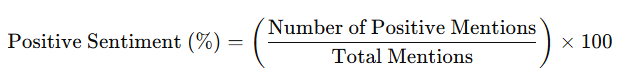

This metric reflects the proportion of posts and comments that express a positive sentiment toward Mastercard relative to the total number of mentions. A higher percentage indicates a generally favorable reception of the brand among community members, and vice versa.

We will look at this measure both on the post and the comment level.

In [12]:
# Determine the % of both positive and negative mentions
pos_count = (df['sentiment_label'] == 'positive').sum()
neg_count = (df['sentiment_label'] == 'negative').sum()
neu_count = (df['sentiment_label'] == 'neutral').sum()

total_count = len(df)
pos_percentage = (pos_count / total_count * 100)
neg_percentage = (neg_count / total_count * 100)

print(f"Positive mentions in post: {pos_count}/{total_count} ({pos_percentage:.2f}%)")
print(f"Positive mentions in post: {neg_count}/{total_count} ({neg_percentage:.2f}%)")

Positive mentions in post: 2/25 (8.00%)
Positive mentions in post: 4/25 (16.00%)


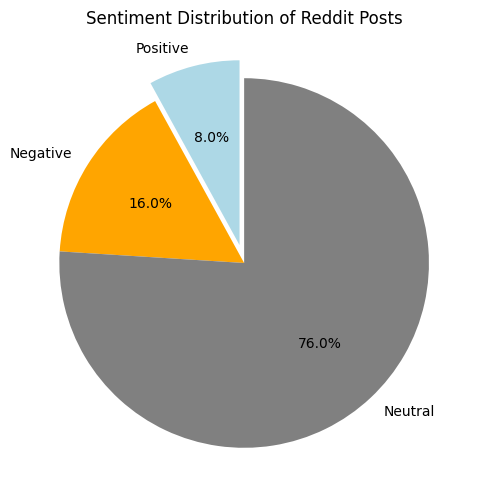

In [13]:
# Labels and values
labels = ['Positive', 'Negative', 'Neutral']
values = [pos_count, neg_count, neu_count]
colors =['lightblue', 'orange', 'grey']
explode = (0.1, 0, 0)  # 

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode)
plt.title("Sentiment Distribution of Reddit Posts")
plt.show()

In [14]:
pos_comment = (df_comment['sentiment_label'] == 'positive').sum()
neg_comment = (df_comment['sentiment_label'] == 'negative').sum()
neu_comment = (df_comment['sentiment_label'] == 'neutral').sum()

total_count = len(df_comment)
pos_com_percentage = (pos_comment / total_count * 100)
neg_com_percentage = (neg_comment / total_count * 100)

print(f"Positive threads in post: {pos_comment}/{total_count} ({pos_com_percentage:.2f}%)")
print(f"Negative threads in post: {neg_comment}/{total_count} ({neg_com_percentage:.2f}%)")

Positive threads in post: 1142/6306 (18.11%)
Negative threads in post: 2142/6306 (33.97%)


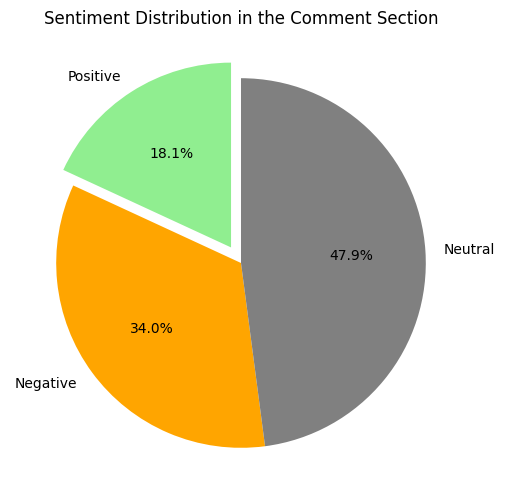

In [15]:
# Labels and values
labels = ['Positive', 'Negative', 'Neutral']
values = [pos_comment, neg_comment, neu_comment]
colors =['lightgreen', 'orange', 'grey']
explode = (0.1, 0, 0)

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode)
plt.title("Sentiment Distribution in the Comment Section")
plt.show()

## 3.2 - What themes and topics are commonly discussed within each sentiment tone?

### Keywords Extraction using tfidf

To understand what concepts are associated with each sentiment, we will extract keywords from every comment thread. Comments will be grouped by their parent ID (lead of the comment thread) to provide context to the conversation. Meaning all text from different comments within the same discussion thread will be concatenated into a single text string. The sentiment assigned to each thread will be determined by the mode sentiment among its comments.

Next, Latent Dirichlet Allocation (LDA) will be applied to these discussion threads, segmented by sentiment, to identify common themes. The extracted keywords will then be aggregated to reveal the most frequently occurring concepts within each sentiment group.

Unlike CardiffNLP’s RoBERTa model, which requires minimal preprocessing, LDA demands more text cleaning to ensure meaningful results. Without proper preprocessing, LDA can produce repetitive or uninformative topics (e.g., “like,” “just,” “does,” “lol”), reflecting common stopwords or weak signals rather than meaningful content.


In [16]:
# Create dfs for each sentiment for theme extraction
grouped_com_df = (
    df_comment
    .groupby('parentID')
    .agg({
        'timestamp': lambda x: x.mode()[0],
        'body': ' '.join,                          
        'sentiment_label': lambda x: x.mode()[0],  
        'sentiment_score': 'mean',                 
        'linkID': 'first'                         
    })
    .reset_index()
)

In [17]:
# Setting up stopwords to preprocess the text
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content

stop_words = set(stopwords_list.decode().splitlines())

# Define Domain specific keywords
custom_stopwords = set(stop_words).union({
    'dont','didnt','game', 'lil', 'year', 'yearly', 'yea', 'yep', 'yeh', 'yup,' 'people', 'yeah', 'got','one','also','like','just', 'people', 'doesnt', 'play', 'league', 'lol'
})

In [18]:
# Method to clean up text
def clean_text(text):
    text = text.lower()                                  
    text = re.sub(r"http\S+", "", text)                  
    text = re.sub(r"[^a-z\s]", "", text)                 
    text = re.sub(r"\s+", " ", text).strip()             
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return text

# Clean text
df['clean_body'] = df['body'].astype(str).apply(clean_text)
grouped_com_df['clean_body'] = grouped_com_df['body'].astype(str).apply(clean_text)

In [19]:
# Split the comment threads by sentiments
neu_grouped = grouped_com_df[grouped_com_df['sentiment_label'] == 'neutral'].copy()
pos_grouped = grouped_com_df[grouped_com_df['sentiment_label'] == 'positive'].copy()
neg_grouped = grouped_com_df[grouped_com_df['sentiment_label'] == 'negative'].copy()

In [20]:
# Extract Key themes from discussion
def extract_themes_lda(df, text_col, n_topics=5, n_top_words=10):

    # Vectorize text
    vectorizer = CountVectorizer(
        stop_words=list(custom_stopwords),
        max_df=0.9,
        min_df=2,
        token_pattern=r'(?u)\b[a-zA-Z]{3,}\b'
    )
    X = vectorizer.fit_transform(df[text_col].astype(str))

    # Fit LDA model
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method='batch'
    )
    lda.fit(X)

    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Extract top words per topic
    topic_keywords = []
    for idx, topic in enumerate(lda.components_):
        top_features = feature_names[topic.argsort()[-n_top_words:][::-1]]
        topic_keywords.append(", ".join(top_features))

    # Assign each row its dominant topic
    topic_distribution = lda.transform(X)
    dominant_topic = topic_distribution.argmax(axis=1)

    # Map topic number to keywords
    topic_map = {i: topic_keywords[i] for i in range(n_topics)}
    df['dominant_topic'] = dominant_topic
    df['topic_keywords'] = df['dominant_topic'].map(topic_map)

    return df

In [21]:
# Calling the method
pos_topics = extract_themes_lda(pos_grouped, 'clean_body')
neu_topics = extract_themes_lda(neu_grouped, 'clean_body')
neg_topics = extract_themes_lda(neg_grouped, 'clean_body')

In [22]:
pos_topics.head()

,parentID,timestamp,body,sentiment_label,sentiment_score,linkID,clean_body,dominant_topic,topic_keywords
4,t1_e67d60i,2018-09-18 20:38:17+00:00,Being a pessimist isn't bad any more than bein...,positive,0.689416,9gwmqn,being a pessimist isnt bad any more than being...,3,"good, jersey, mikes, subway, love, thing, pres..."
10,t1_e67e7pr,2018-09-18 17:36:54+00:00,"Quite the opposite, imo. You're hardly ever di...",positive,0.721666,9gwmqn,quite the opposite imo youre hardly ever disap...,0,"good, song, live, ceremony, performance, openi..."
25,t1_e67frvc,2018-09-18 19:09:39+00:00,Not even a real commercial and that's my favor...,positive,0.788978,9gwmqn,not even a real commercial and thats my favori...,2,"lcs, time, watching, man, lot, years, thought,..."
47,t1_e67ho5q,2018-09-18 18:27:24+00:00,"Jersey Mikes has all the meats, cheese, etc st...",positive,0.779788,9gwmqn,jersey mikes has all the meats cheese etc stil...,3,"good, jersey, mikes, subway, love, thing, pres..."
54,t1_e67i571,2018-09-18 18:32:49+00:00,As someone who eats subway every other day. I ...,positive,0.649081,9gwmqn,as someone who eats subway every other day i c...,3,"good, jersey, mikes, subway, love, thing, pres..."


In [23]:
# Pivot string of keywords into rows
def expand_topic_keywords(df, keyword_col='topic_keywords'):
    df['keyword_list'] = df[keyword_col].astype(str).str.split(r',\s*')
    
    exploded_df = df.explode('keyword_list', ignore_index=True)
    exploded_df['keyword_list'] = exploded_df['keyword_list'].str.strip()
    
    exploded_df = exploded_df.dropna(subset=['keyword_list'])
    exploded_df = exploded_df.rename(columns={'keyword_list': 'Keyword'})
    
    return exploded_df

In [24]:
# Calling the method
pos_expanded = expand_topic_keywords(pos_topics)
neu_expanded = expand_topic_keywords(neu_topics)
neg_expanded = expand_topic_keywords(neg_topics)

# Concat all keywords
all_keywords = pd.concat(
    [pos_expanded, neu_expanded, neg_expanded],
    ignore_index=True
)

keywords = all_keywords.drop(['body', 'clean_body', 'dominant_topic'], axis = 1)

# Save for viz
keywords.to_csv('keywords.csv')

In [33]:
# Inspect Result
print(f'Positive Topics:\n{pos_expanded['topic_keywords'].unique()}')
print(f'\nNegative Topics:\n{neg_expanded['topic_keywords'].unique()}')

Positive Topics:
['good, jersey, mikes, subway, love, thing, pressure, pretty, geng, big'
 'good, song, live, ceremony, performance, opening, fucking, pretty, linkin, worlds'
 'lcs, time, watching, man, lot, years, thought, hype, hope, person'
 'card, good, worlds, games, cool, work, tsm, scene, money, lot'
 'queue, flex, good, imagine, hype, riot, win, dragons, played, great']

Negative Topics:
['riot, good, worlds, song, bad, pretty, live, performance, deal, lcs'
 'queue, flex, solo, duo, playing, duos, ranked, rank, players, team'
 'tickets, mastercard, scalpers, worlds, buy, ticket, price, thing, riot, time'
 'win, team, riot, gold, probability, time, years, work, money, point'
 'tickets, queue, geng, chovy, doran, lck, team, good, sold, games']


In [25]:
# Count occurrences of each keyword by sentiment
word_counts = (
    keywords.groupby(['sentiment_label', 'Keyword'])
    .size()
    .reset_index(name='count')
)

word_counts.head()

# Save to csv
word_counts.to_csv('word_count.csv')

In [26]:
# Drop unused columns
post_cleaned = df.drop(
    ['title', 'body', 'commentIDs'], 
    axis=1, 
)
comment_cleaned = df_comment.drop(
    ['body'], 
    axis = 1)

thread_cleaned = grouped_com_df.drop(
    ['body'], 
    axis = 1)

# Save to CSV
post_cleaned.to_csv('post_results.csv', index=False)
comment_cleaned.to_csv('comment_results.csv')
thread_cleaned.to_csv('thread_cleaned.csv')